In [3]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [4]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-12-13 01:13:17--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  28.3MB/s    in 4.2s    

2024-12-13 01:13:22 (25.1 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [5]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [7]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [8]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [9]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [10]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [12]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 13.79it/s]


Epoch 1, Train Loss: 2.319, Train Accuracy: 13.50%
Epoch 1, Val Loss: 2.244, Val Accuracy: 21.20%


100%|██████████| 16/16 [00:00<00:00, 20.35it/s]


Epoch 2, Train Loss: 2.132, Train Accuracy: 29.40%
Epoch 2, Val Loss: 1.980, Val Accuracy: 42.40%


100%|██████████| 16/16 [00:00<00:00, 20.67it/s]


Epoch 3, Train Loss: 1.576, Train Accuracy: 50.40%
Epoch 3, Val Loss: 1.070, Val Accuracy: 64.00%


100%|██████████| 16/16 [00:00<00:00, 20.87it/s]


Epoch 4, Train Loss: 0.951, Train Accuracy: 67.00%
Epoch 4, Val Loss: 0.715, Val Accuracy: 74.40%


100%|██████████| 16/16 [00:00<00:00, 21.33it/s]


Epoch 5, Train Loss: 0.665, Train Accuracy: 78.50%
Epoch 5, Val Loss: 0.538, Val Accuracy: 81.80%
Treinamento concluído


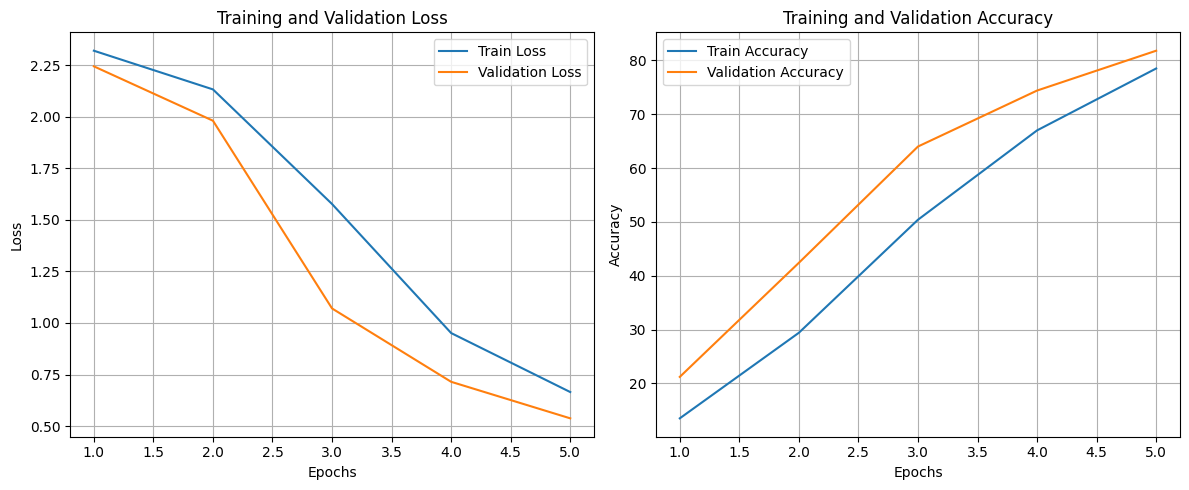

In [13]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
test_model(model, testloader)

Acurácia da rede na base de teste: 87.00%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [18]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_1=6, num_filters_2=12):
        super(CNN, self).__init__()
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

comb_param = [
    (6, 12),
    (8, 12),
    (6, 16),
    (8, 16)
]

for num_filters_1, num_filters_2 in comb_param:
  print(f'Combinação de filtros ({num_filters_1}, {num_filters_2})')
  model = CNN(
      initialize_weights=True,
      dropout=0.2,
      num_filters_1=num_filters_1,
      num_filters_2=num_filters_2
  )
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  # Treinando a CNN
  history = train_model(
      model=model,
      trainloader=trainloader,
      valloader=valloader,
      criterion=criterion,
      optimizer=optimizer
  )
  test_model(model, testloader)
  print()

Combinação de filtros (6, 12)


100%|██████████| 16/16 [00:00<00:00, 18.31it/s]


Epoch 1, Train Loss: 2.269, Train Accuracy: 15.20%
Epoch 1, Val Loss: 2.189, Val Accuracy: 32.60%


100%|██████████| 16/16 [00:00<00:00, 19.79it/s]


Epoch 2, Train Loss: 2.060, Train Accuracy: 32.80%
Epoch 2, Val Loss: 1.821, Val Accuracy: 43.60%


100%|██████████| 16/16 [00:00<00:00, 20.65it/s]


Epoch 3, Train Loss: 1.470, Train Accuracy: 54.60%
Epoch 3, Val Loss: 0.925, Val Accuracy: 72.40%


100%|██████████| 16/16 [00:00<00:00, 19.16it/s]


Epoch 4, Train Loss: 0.838, Train Accuracy: 72.50%
Epoch 4, Val Loss: 0.612, Val Accuracy: 82.40%


100%|██████████| 16/16 [00:00<00:00, 19.06it/s]


Epoch 5, Train Loss: 0.591, Train Accuracy: 79.90%
Epoch 5, Val Loss: 0.521, Val Accuracy: 81.60%
Treinamento concluído
Acurácia da rede na base de teste: 84.60%

Combinação de filtros (8, 12)


100%|██████████| 16/16 [00:01<00:00, 14.42it/s]


Epoch 1, Train Loss: 2.252, Train Accuracy: 16.50%
Epoch 1, Val Loss: 2.108, Val Accuracy: 39.20%


100%|██████████| 16/16 [00:01<00:00, 13.27it/s]


Epoch 2, Train Loss: 1.836, Train Accuracy: 39.40%
Epoch 2, Val Loss: 1.348, Val Accuracy: 62.40%


100%|██████████| 16/16 [00:01<00:00, 13.58it/s]


Epoch 3, Train Loss: 1.132, Train Accuracy: 63.50%
Epoch 3, Val Loss: 0.809, Val Accuracy: 72.20%


100%|██████████| 16/16 [00:00<00:00, 19.15it/s]


Epoch 4, Train Loss: 0.730, Train Accuracy: 75.00%
Epoch 4, Val Loss: 0.518, Val Accuracy: 83.40%


100%|██████████| 16/16 [00:00<00:00, 19.46it/s]


Epoch 5, Train Loss: 0.546, Train Accuracy: 81.70%
Epoch 5, Val Loss: 0.433, Val Accuracy: 87.40%
Treinamento concluído
Acurácia da rede na base de teste: 88.80%

Combinação de filtros (6, 16)


100%|██████████| 16/16 [00:00<00:00, 18.82it/s]


Epoch 1, Train Loss: 2.284, Train Accuracy: 14.20%
Epoch 1, Val Loss: 2.215, Val Accuracy: 20.40%


100%|██████████| 16/16 [00:00<00:00, 19.19it/s]


Epoch 2, Train Loss: 2.111, Train Accuracy: 25.50%
Epoch 2, Val Loss: 1.910, Val Accuracy: 42.00%


100%|██████████| 16/16 [00:00<00:00, 17.68it/s]


Epoch 3, Train Loss: 1.577, Train Accuracy: 50.80%
Epoch 3, Val Loss: 0.958, Val Accuracy: 76.00%


100%|██████████| 16/16 [00:00<00:00, 20.31it/s]


Epoch 4, Train Loss: 0.815, Train Accuracy: 74.90%
Epoch 4, Val Loss: 0.550, Val Accuracy: 84.00%


100%|██████████| 16/16 [00:00<00:00, 20.31it/s]


Epoch 5, Train Loss: 0.538, Train Accuracy: 81.60%
Epoch 5, Val Loss: 0.382, Val Accuracy: 88.20%
Treinamento concluído
Acurácia da rede na base de teste: 89.40%

Combinação de filtros (8, 16)


100%|██████████| 16/16 [00:00<00:00, 17.30it/s]


Epoch 1, Train Loss: 2.250, Train Accuracy: 18.10%
Epoch 1, Val Loss: 2.033, Val Accuracy: 47.40%


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


Epoch 2, Train Loss: 1.717, Train Accuracy: 47.80%
Epoch 2, Val Loss: 1.027, Val Accuracy: 73.60%


100%|██████████| 16/16 [00:01<00:00, 14.01it/s]


Epoch 3, Train Loss: 0.927, Train Accuracy: 71.80%
Epoch 3, Val Loss: 0.566, Val Accuracy: 83.00%


100%|██████████| 16/16 [00:00<00:00, 20.83it/s]


Epoch 4, Train Loss: 0.630, Train Accuracy: 79.50%
Epoch 4, Val Loss: 0.411, Val Accuracy: 87.20%


100%|██████████| 16/16 [00:00<00:00, 20.64it/s]


Epoch 5, Train Loss: 0.446, Train Accuracy: 85.00%
Epoch 5, Val Loss: 0.330, Val Accuracy: 89.20%
Treinamento concluído
Acurácia da rede na base de teste: 91.00%



A combinação de filtros (8, 16) obteve a maior acurácia de teste: 91.00%

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [20]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_1=6, num_filters_2=12, num_hidden=64):
        super(CNN, self).__init__()
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, num_hidden)
        self.fc2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



In [21]:
for i in range(5):
    num_neurons = np.random.randint(10, 100)
    model = CNN(
      initialize_weights=True,
      dropout=0.2,
      num_hidden=num_neurons
    )
    print(f'Número de neurônios: {num_neurons}')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # Treinando a CNN
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )
    test_model(model, testloader)
    print()
    #history = ...

Número de neurônios: 78


100%|██████████| 16/16 [00:00<00:00, 20.91it/s]


Epoch 1, Train Loss: 2.293, Train Accuracy: 15.40%
Epoch 1, Val Loss: 2.245, Val Accuracy: 22.80%


100%|██████████| 16/16 [00:00<00:00, 21.02it/s]


Epoch 2, Train Loss: 2.141, Train Accuracy: 30.00%
Epoch 2, Val Loss: 1.936, Val Accuracy: 44.20%


100%|██████████| 16/16 [00:00<00:00, 21.38it/s]


Epoch 3, Train Loss: 1.563, Train Accuracy: 49.90%
Epoch 3, Val Loss: 1.009, Val Accuracy: 67.80%


100%|██████████| 16/16 [00:00<00:00, 21.12it/s]


Epoch 4, Train Loss: 0.893, Train Accuracy: 69.20%
Epoch 4, Val Loss: 0.651, Val Accuracy: 77.00%


100%|██████████| 16/16 [00:00<00:00, 19.74it/s]


Epoch 5, Train Loss: 0.567, Train Accuracy: 81.20%
Epoch 5, Val Loss: 0.515, Val Accuracy: 83.20%
Treinamento concluído
Acurácia da rede na base de teste: 86.40%

Número de neurônios: 90


100%|██████████| 16/16 [00:01<00:00, 15.23it/s]


Epoch 1, Train Loss: 2.295, Train Accuracy: 12.90%
Epoch 1, Val Loss: 2.219, Val Accuracy: 22.20%


100%|██████████| 16/16 [00:01<00:00, 14.51it/s]


Epoch 2, Train Loss: 2.053, Train Accuracy: 31.00%
Epoch 2, Val Loss: 1.735, Val Accuracy: 54.00%


100%|██████████| 16/16 [00:00<00:00, 21.07it/s]


Epoch 3, Train Loss: 1.358, Train Accuracy: 57.60%
Epoch 3, Val Loss: 0.778, Val Accuracy: 77.40%


100%|██████████| 16/16 [00:00<00:00, 20.51it/s]


Epoch 4, Train Loss: 0.727, Train Accuracy: 76.90%
Epoch 4, Val Loss: 0.507, Val Accuracy: 84.20%


100%|██████████| 16/16 [00:00<00:00, 20.58it/s]


Epoch 5, Train Loss: 0.463, Train Accuracy: 85.80%
Epoch 5, Val Loss: 0.429, Val Accuracy: 86.40%
Treinamento concluído
Acurácia da rede na base de teste: 88.20%

Número de neurônios: 61


100%|██████████| 16/16 [00:00<00:00, 20.81it/s]


Epoch 1, Train Loss: 2.300, Train Accuracy: 13.00%
Epoch 1, Val Loss: 2.244, Val Accuracy: 18.20%


100%|██████████| 16/16 [00:00<00:00, 20.79it/s]


Epoch 2, Train Loss: 2.173, Train Accuracy: 20.40%
Epoch 2, Val Loss: 2.032, Val Accuracy: 32.20%


100%|██████████| 16/16 [00:00<00:00, 20.91it/s]


Epoch 3, Train Loss: 1.775, Train Accuracy: 41.60%
Epoch 3, Val Loss: 1.254, Val Accuracy: 65.40%


100%|██████████| 16/16 [00:00<00:00, 20.66it/s]


Epoch 4, Train Loss: 0.973, Train Accuracy: 67.10%
Epoch 4, Val Loss: 0.595, Val Accuracy: 82.40%


100%|██████████| 16/16 [00:00<00:00, 20.32it/s]


Epoch 5, Train Loss: 0.623, Train Accuracy: 80.00%
Epoch 5, Val Loss: 0.414, Val Accuracy: 87.80%
Treinamento concluído
Acurácia da rede na base de teste: 89.00%

Número de neurônios: 20


100%|██████████| 16/16 [00:00<00:00, 18.59it/s]


Epoch 1, Train Loss: 2.326, Train Accuracy: 12.70%
Epoch 1, Val Loss: 2.281, Val Accuracy: 12.60%


100%|██████████| 16/16 [00:01<00:00, 15.59it/s]


Epoch 2, Train Loss: 2.220, Train Accuracy: 20.30%
Epoch 2, Val Loss: 2.195, Val Accuracy: 20.80%


100%|██████████| 16/16 [00:01<00:00, 14.06it/s]


Epoch 3, Train Loss: 2.079, Train Accuracy: 27.00%
Epoch 3, Val Loss: 1.948, Val Accuracy: 35.40%


100%|██████████| 16/16 [00:00<00:00, 20.80it/s]


Epoch 4, Train Loss: 1.758, Train Accuracy: 39.80%
Epoch 4, Val Loss: 1.426, Val Accuracy: 58.40%


100%|██████████| 16/16 [00:00<00:00, 20.51it/s]


Epoch 5, Train Loss: 1.292, Train Accuracy: 55.60%
Epoch 5, Val Loss: 0.897, Val Accuracy: 69.20%
Treinamento concluído
Acurácia da rede na base de teste: 69.80%

Número de neurônios: 31


100%|██████████| 16/16 [00:00<00:00, 21.46it/s]


Epoch 1, Train Loss: 2.306, Train Accuracy: 11.50%
Epoch 1, Val Loss: 2.251, Val Accuracy: 11.60%


100%|██████████| 16/16 [00:00<00:00, 20.77it/s]


Epoch 2, Train Loss: 2.168, Train Accuracy: 22.10%
Epoch 2, Val Loss: 2.094, Val Accuracy: 30.80%


100%|██████████| 16/16 [00:00<00:00, 20.43it/s]


Epoch 3, Train Loss: 1.880, Train Accuracy: 39.30%
Epoch 3, Val Loss: 1.566, Val Accuracy: 55.00%


100%|██████████| 16/16 [00:00<00:00, 21.01it/s]


Epoch 4, Train Loss: 1.338, Train Accuracy: 55.90%
Epoch 4, Val Loss: 0.864, Val Accuracy: 76.20%


100%|██████████| 16/16 [00:00<00:00, 21.47it/s]


Epoch 5, Train Loss: 0.848, Train Accuracy: 70.50%
Epoch 5, Val Loss: 0.736, Val Accuracy: 78.40%
Treinamento concluído
Acurácia da rede na base de teste: 79.20%

